# 02_quant_basics.ipynb

# 📘 章节目标：
# 本章将开展高斯参数量化与压缩的基础实验，探索线性、对数、向量量化等方式
# 并结合前一章分析结果评估不同策略对存储效率和误差的影响

In [1]:
import numpy as np
import matplotlib.pyplot as plt

base_path = "../data/drjohnson/"

means3D = np.load(base_path + "means3D.npy")
opacity = np.load(base_path + "opacity.npy")
rotations = np.load(base_path + "rotations.npy")
scales = np.load(base_path + "scales.npy")
sh = np.load(base_path + "sh.npy")

print("means3D:", means3D.shape)
print("opacity:", opacity.shape)
print("rotations:", rotations.shape)
print("scales:", scales.shape)
print("sh:", sh.shape)

# Plot configuration

plt.rcParams.update({
    "font.size": 12,
    "font.weight": "bold",           # 全局加粗
    "axes.titlesize": 12,
    "axes.labelsize": 12,
    "axes.labelweight": "bold",      # 坐标轴标题加粗
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "xtick.major.width": 0,        # 可以加粗刻度线
    "ytick.major.width": 0,
    "xtick.direction": "inout",
    "ytick.direction": "inout",
    "xtick.major.size": 6,
    "ytick.major.size": 6,
    "legend.fontsize": 12,
    "legend.title_fontsize": 12,
})

means3D: (3405153, 3)
opacity: (3405153, 1)
rotations: (3405153, 4)
scales: (3405153, 3)
sh: (3405153, 16, 3)


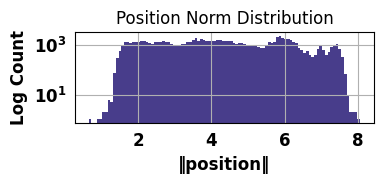

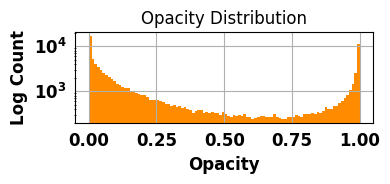

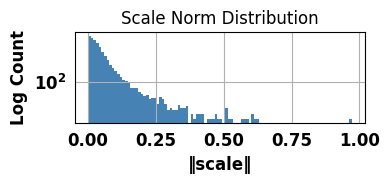

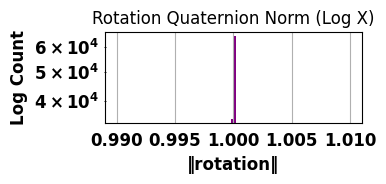

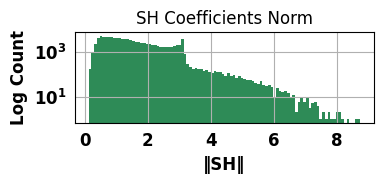

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# 假设 means3D, scales, rotations, opacity, sh 都已加载
idx = np.random.choice(len(opacity), size=100000, replace=False)

# 1️⃣ Position 范数分布（means3D）
position_norm = np.linalg.norm(means3D, axis=1)
plt.figure(figsize=(4,2))
plt.hist(position_norm[idx], bins=100, color='darkslateblue')
plt.title("Position Norm Distribution")
plt.xlabel("‖position‖")
plt.ylabel("Log Count")
plt.yscale("log")
plt.grid(True)
plt.tight_layout()
plt.show()

# 2️⃣ Opacity 分布
plt.figure(figsize=(4,2))
plt.hist(opacity[idx].flatten(), bins=100, color='darkorange')
plt.title("Opacity Distribution")
plt.xlabel("Opacity")
plt.ylabel("Log Count")
plt.yscale("log")
plt.grid(True)
plt.tight_layout()
plt.show()

# 3️⃣ Scale 大小（L2 范数）
scale_norm = np.linalg.norm(scales, axis=1)
plt.figure(figsize=(4,2))
plt.hist(scale_norm[idx], bins=100, color='steelblue')
plt.title("Scale Norm Distribution")
plt.xlabel("‖scale‖")
plt.ylabel("Log Count")
plt.yscale("log")
plt.grid(True)
plt.tight_layout()
plt.show()

# 4️⃣ Rotation 四元数范数（log 横轴）
rot_norm = np.linalg.norm(rotations, axis=1)
plt.figure(figsize=(4,2))
plt.hist(rot_norm[idx], bins=100,range=(0.99, 1.01), color='purple')
plt.title("Rotation Quaternion Norm (Log X)")
plt.xlabel("‖rotation‖")
plt.ylabel("Log Count")
plt.yscale("log")
plt.grid(True)
plt.tight_layout()
plt.show()

# 5️⃣ SH 强度（L2）
sh_strength = np.linalg.norm(sh.reshape(len(sh), -1), axis=1)
plt.figure(figsize=(4,2))
plt.hist(sh_strength[idx], bins=100, color='seagreen')
plt.title("SH Coefficients Norm")
plt.xlabel("‖SH‖")
plt.ylabel("Log Count")
plt.yscale("log")
plt.grid(True)
plt.tight_layout()
plt.show()

# ✅ 2.2 单变量量化模拟

### 📐 为什么要衡量量化误差？

在高斯参数压缩过程中，量化是降低位宽、减小存储和带宽开销的关键手段。但量化不可避免会引入精度损失，甚至影响渲染质量。因此，我们需要对量化前后的差异进行系统评估，量化这一“失真程度”。

---

### 🧮 衡量量化误差的常用指标：

#### 1. **均方误差（MSE, Mean Squared Error）**
- 计算原始值与量化还原值之间的平均平方差：
  
  $$
  \text{MSE} = \frac{1}{N} \sum_{i=1}^N (x_i - \hat{x}_i)^2
  $$

- MSE 越小，表示压缩后还原越准确。

#### 2. **峰值信噪比（PSNR, Peak Signal-to-Noise Ratio）**
- 以分贝为单位，度量重建信号相对于误差的比值：

  $$
  \text{PSNR} = 20 \cdot \log_{10}\left( \frac{\text{MAX}}{\sqrt{\text{MSE}}} \right)
  $$

- 其中 `MAX` 是原始数据的最大值（可理解为信号动态范围）；
- 通常：
  - **30 dB 以下** → 明显失真；
  - **30–40 dB** → 可接受；
  - **40 dB 以上** → 几乎无感知误差。

---

### 📊 误差可视化推荐：

- **原始值 vs 量化值散点图**：直观展现压缩保真性；
- **残差直方图**：观察误差集中程度与偏移；
- **PSNR/MSE 曲线 vs 位宽**：量化策略评估的核心基准。

---

### ✅ 总结：

在压缩设计中，MSE 提供精确误差量化，PSNR 提供对重建质量的感知尺度，二者互补，是评估量化效果不可或缺的指标组合。


In [18]:
def linear_quantize(x, bits, vmin=None, vmax=None):
    if vmin is None: vmin = x.min()
    if vmax is None: vmax = x.max()
    levels = 2 ** bits
    x_clipped = np.clip(x, vmin, vmax)
    x_norm = (x_clipped - vmin) / (vmax - vmin)
    q = np.round(x_norm * (levels - 1))
    x_dequant = q / (levels - 1) * (vmax - vmin) + vmin
    return x_dequant, q

def log_quantize(x, bits, eps=1e-6):
    x_safe = np.clip(x, eps, None)
    log_x = np.log(x_safe)
    log_dequant, q = linear_quantize(log_x, bits)
    x_recon = np.exp(log_dequant)  # ✅ 反量化，回到原始空间
    return x_recon, q

def psnr(original, quantized):
    mse = np.mean((original - quantized) ** 2)
    if mse == 0:
        return float('inf')
    max_val = np.max(original)
    return 20 * np.log10(max_val / np.sqrt(mse))

def run_quant_analysis(name, array, method='linear', bits=4):
    print(f"\n▶️ Quantizing [{name}] using {method}-based {bits}-bit...")
    x = array.flatten()
    vmin, vmax = x.min(), x.max()

    if method == 'linear':
        recon, _ = linear_quantize(x, bits, vmin, vmax)
    elif method == 'log':
        recon, _ = log_quantize(x, bits)
    else:
        raise ValueError("Unsupported method")

    # PSNR + MSE
    error = np.mean((x - recon) ** 2)
    p = psnr(x, recon)
    print(f"MSE: {error:.4e}, PSNR: {p:.2f} dB")

    # 散点图
    plt.figure(figsize=(4,3))
    plt.scatter(x[idx], recon[idx], s=1, alpha=0.3)
    plt.xlabel("Original")
    plt.ylabel("Quantized")
    plt.title(f"{name} {bits}-bit {method.capitalize()} Quantization")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 残差分布
    residual = x[idx] - recon[idx]
    plt.figure(figsize=(4,2))
    plt.hist(residual, bins=100, color='tomato')
    plt.title(f"{name} {bits}-bit Residual Distribution")
    plt.xlabel("Error")
    plt.ylabel("Log Count")
    plt.yscale("log")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### 📏 线性量化与对数量化：原理与适用范围

为了压缩高斯参数如 `opacity`, `scale`, `SH coefficients` 等浮点属性，我们通常使用 **线性量化（Linear Quantization）** 或 **对数量化（Log Quantization）**。两者各有优势，适用于不同类型的属性值分布。

---

### 1️⃣ 线性量化（Linear Quantization）

#### ✅ 适用范围：
- 值域变化 **较小（span < 10×）** 的属性，如 `opacity`, `position_norm`
- 分布相对均匀，**无需特别强调低值精度**

#### 📐 公式：

设变量 $x$ 的最小值为 $x_{\min}$，最大值为 $x_{\max}$，位宽为 $b$，总共有 $2^b$ 个离散值。

**量化：**
$$
q = \left\lfloor \frac{x - x_{\min}}{x_{\max} - x_{\min}} \cdot (2^b - 1) \right\rceil
$$

**反量化（重建）：**
$$
\hat{x} = \frac{q}{2^b - 1} \cdot (x_{\max} - x_{\min}) + x_{\min}
$$

---

### 2️⃣ 对数量化（Log Quantization）

#### ✅ 适用范围：
- 值域变化 **巨大（dynamic range > 100×）** 的属性，如 `scale`, `SH norm`
- 低值区占主导，需要精细区分小数值差异
- 分布偏斜、呈指数衰减的场景

#### 📐 公式：

引入小正数 $\varepsilon$（防止 $\log(0)$），对原始值取对数，再做线性量化：

**量化：**
$$
q = \left\lfloor \frac{\log(x + \varepsilon) - \log(x_{\min} + \varepsilon)}{\log(x_{\max} + \varepsilon) - \log(x_{\min} + \varepsilon)} \cdot (2^b - 1) \right\rceil
$$

**反量化（重建）：**
$$
\hat{x} = \exp \left( \frac{q}{2^b - 1} \cdot \left[\log(x_{\max} + \varepsilon) - \log(x_{\min} + \varepsilon)\right] + \log(x_{\min} + \varepsilon) \right) - \varepsilon
$$

---

### 🧠 总结：

| 属性类型     | 推荐方法     | 原因                     |
|--------------|--------------|--------------------------|
| Opacity      | 线性量化     | 分布稳定，范围 0~1       |
| Scale norm   | 对数量化 ✅  | 小值集中，dynamic range 巨大 |
| SH 强度      | 对数量化     | 能量集中于低阶分量       |
| Rotation norm| 线性量化     | 通常归一化，接近常数分布 |

通过结合不同的量化策略，我们可以在保证压缩率的同时，尽可能保留关键渲染属性的精度。



▶️ Quantizing [Opacity] using linear-based 4-bit...
MSE: 2.8878e-04, PSNR: 35.39 dB


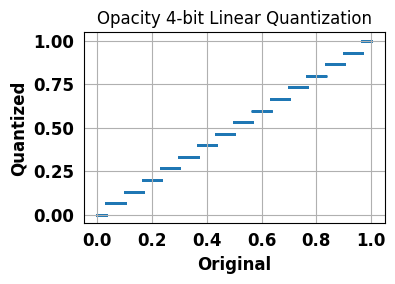

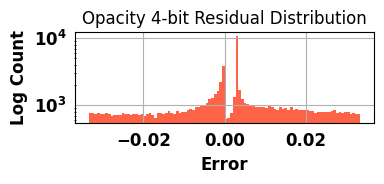


▶️ Quantizing [Opacity] using log-based 4-bit...
MSE: 2.2286e-03, PSNR: 26.52 dB


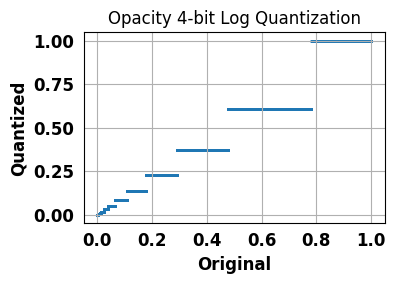

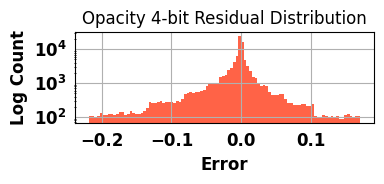

In [19]:
# 对 opacity 做线性和对数量化
run_quant_analysis("Opacity", opacity, method='linear', bits=4)
run_quant_analysis("Opacity", opacity, method='log', bits=4)


▶️ Quantizing [Opacity] using linear-based 8-bit...
MSE: 1.1793e-06, PSNR: 59.28 dB


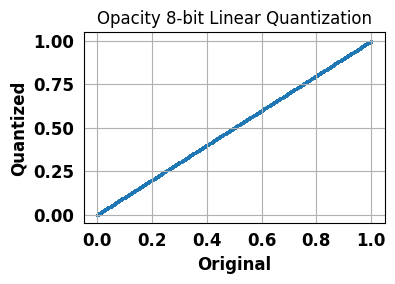

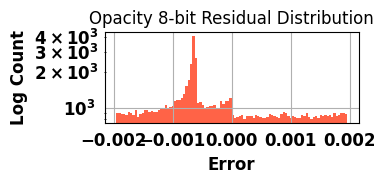


▶️ Quantizing [Opacity] using log-based 8-bit...
MSE: 1.3979e-05, PSNR: 48.55 dB


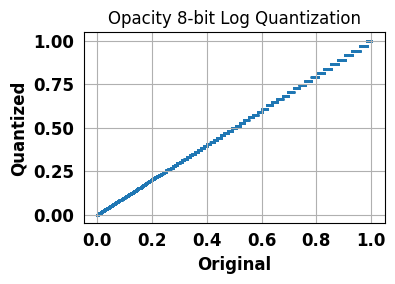

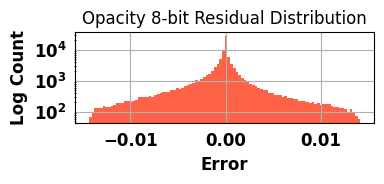

In [20]:
# 对 opacity 做线性和对数量化
run_quant_analysis("Opacity", opacity, method='linear', bits=8)
run_quant_analysis("Opacity", opacity, method='log', bits=8)


▶️ Quantizing [Scale norm] using linear-based 4-bit...
MSE: 4.5556e-04, PSNR: 34.81 dB


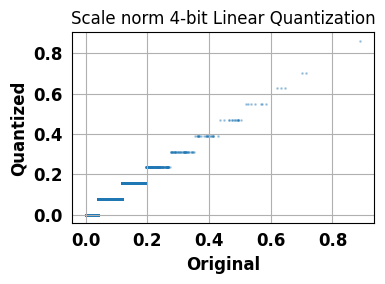

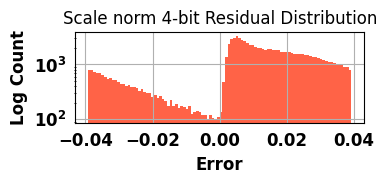


▶️ Quantizing [Scale norm] using log-based 4-bit...
MSE: 5.2833e-05, PSNR: 44.17 dB


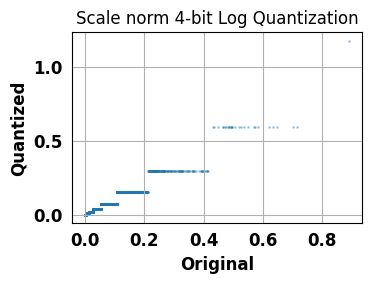

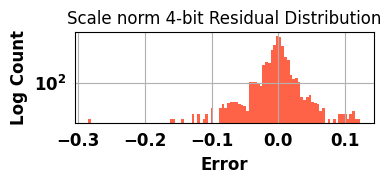

In [21]:

run_quant_analysis("Scale norm", scale_norm, method='linear', bits=4)
run_quant_analysis("Scale norm", scale_norm, method='log', bits=4)


▶️ Quantizing [Scale norm] using linear-based 8-bit...
MSE: 1.7712e-06, PSNR: 58.91 dB


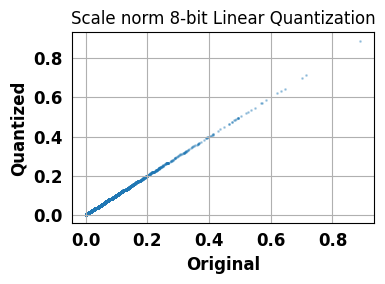

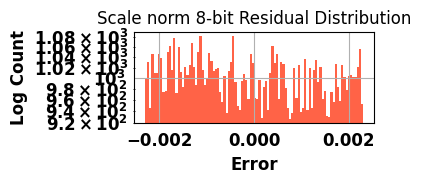


▶️ Quantizing [Scale norm] using log-based 8-bit...
MSE: 1.7522e-07, PSNR: 68.96 dB


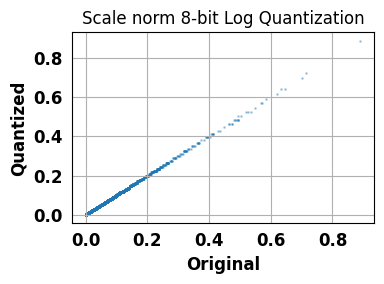

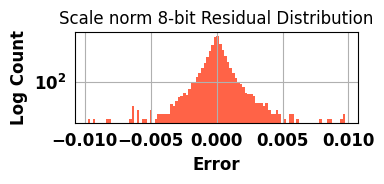

In [22]:

run_quant_analysis("Scale norm", scale_norm, method='linear', bits=8)
run_quant_analysis("Scale norm", scale_norm, method='log', bits=8)


▶️ Quantizing [Position norm] using linear-based 4-bit...
MSE: 3.4676e-02, PSNR: 34.64 dB


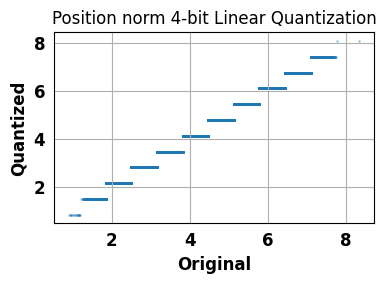

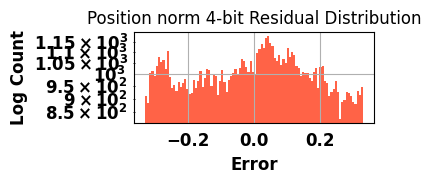


▶️ Quantizing [Position norm] using log-based 4-bit...
MSE: 1.0105e-01, PSNR: 30.00 dB


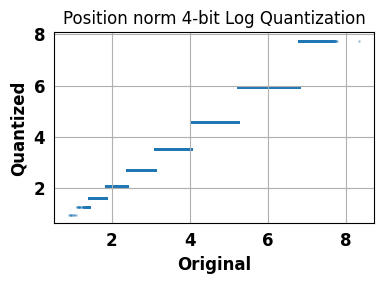

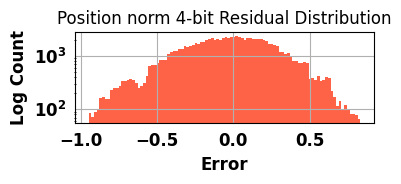

In [23]:

run_quant_analysis("Position norm", position_norm, method='linear', bits=4)
run_quant_analysis("Position norm", position_norm, method='log', bits=4)


▶️ Quantizing [Position norm] using linear-based 8-bit...
MSE: 1.2468e-04, PSNR: 59.08 dB


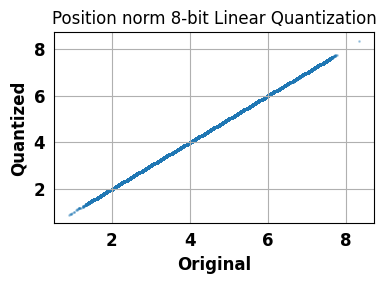

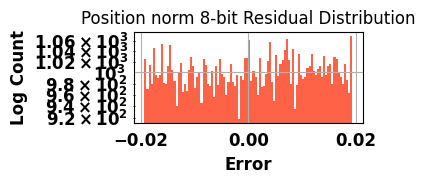


▶️ Quantizing [Position norm] using log-based 8-bit...
MSE: 4.1940e-04, PSNR: 53.82 dB


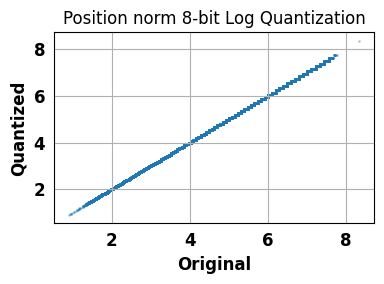

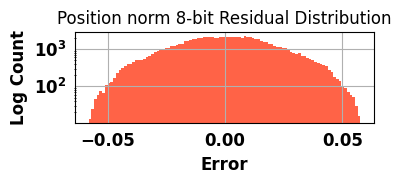

In [24]:

run_quant_analysis("Position norm", position_norm, method='linear', bits=8)
run_quant_analysis("Position norm", position_norm, method='log', bits=8)


▶️ Quantizing [SH strength] using linear-based 4-bit...
MSE: 3.6217e-02, PSNR: 34.16 dB


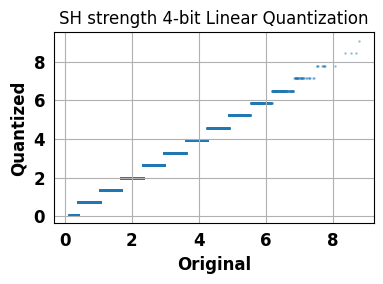

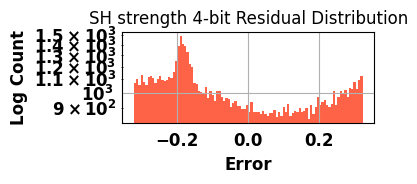


▶️ Quantizing [SH strength] using log-based 4-bit...
MSE: 3.7427e-02, PSNR: 34.02 dB


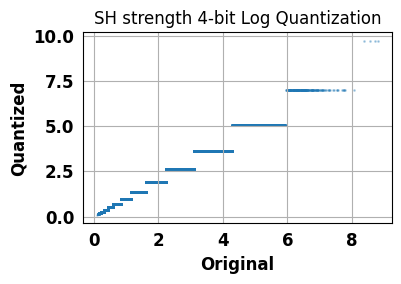

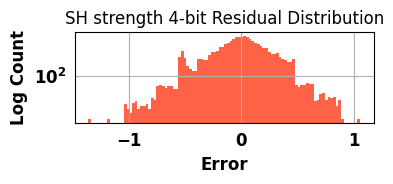

In [25]:

run_quant_analysis("SH strength", sh_strength, method='linear', bits=4)
run_quant_analysis("SH strength", sh_strength, method='log', bits=4)


▶️ Quantizing [SH strength] using linear-based 8-bit...
MSE: 1.1891e-04, PSNR: 59.00 dB


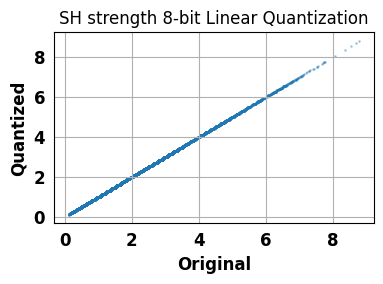

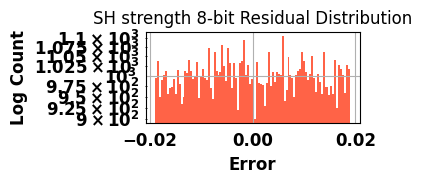


▶️ Quantizing [SH strength] using log-based 8-bit...
MSE: 1.0750e-04, PSNR: 59.44 dB


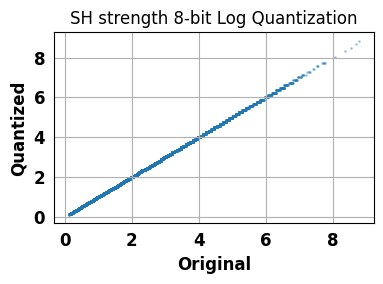

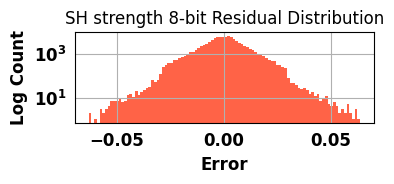

In [27]:
run_quant_analysis("SH strength", sh_strength, method='linear', bits=8)
run_quant_analysis("SH strength", sh_strength, method='log', bits=8)

# ✅ 2.3 Opacity 的混合精度策略（分段分位）
### 上一节只有scale在log策略下量化到4bit表现优异，所以可能需要进一步混合比特的分析。


🔀 Mixed-Precision Opacity Quantization:
Split: low<0.3, mid, high>0.7 → Bits: (4, 3, 4)
Count: low=2063784, mid=455737, high=885632, total=3405153
→ Avg Bits per value: 3.87 bits
MSE: 6.1130e-05, PSNR: 42.14 dB


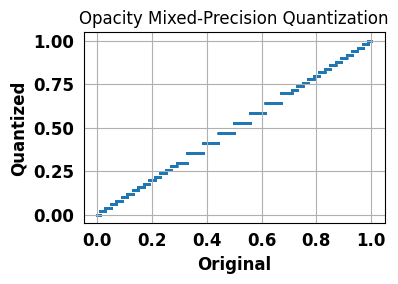

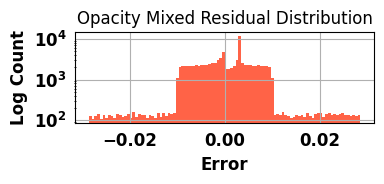

In [35]:
def mixed_precision_opacity_quantize(opacity, thresholds=(0.3, 0.7), bits=(6, 3, 5)):
    low_th, high_th = thresholds
    b_low, b_mid, b_high = bits

    x = opacity.flatten()
    x_quant = np.zeros_like(x)

    low_mask = x < low_th
    high_mask = x > high_th
    mid_mask = ~(low_mask | high_mask)

    recon_low, _ = linear_quantize(x[low_mask], b_low)
    recon_mid, _ = linear_quantize(x[mid_mask], b_mid)
    recon_high, _ = linear_quantize(x[high_mask], b_high)

    x_quant[low_mask] = recon_low
    x_quant[mid_mask] = recon_mid
    x_quant[high_mask] = recon_high

    mse = np.mean((x - x_quant) ** 2)
    psnr_val = psnr(x, x_quant)

    # ✅ 评估平均 bit 使用量
    num_low, num_mid, num_high = low_mask.sum(), mid_mask.sum(), high_mask.sum()
    total = len(x)
    avg_bits = (num_low * b_low + num_mid * b_mid + num_high * b_high) / total

    print(f"\n🔀 Mixed-Precision Opacity Quantization:")
    print(f"Split: low<{low_th}, mid, high>{high_th} → Bits: {bits}")
    print(f"Count: low={num_low}, mid={num_mid}, high={num_high}, total={total}")
    print(f"→ Avg Bits per value: {avg_bits:.2f} bits")
    print(f"MSE: {mse:.4e}, PSNR: {psnr_val:.2f} dB")

    plt.figure(figsize=(4,3))
    plt.scatter(x[idx], x_quant[idx], s=1, alpha=0.3)
    plt.xlabel("Original")
    plt.ylabel("Quantized")
    plt.title("Opacity Mixed-Precision Quantization")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(4,2))
    residual = x[idx] - x_quant[idx]
    plt.hist(residual, bins=100, color='tomato')
    plt.title("Opacity Mixed Residual Distribution")
    plt.xlabel("Error")
    plt.ylabel("Log Count")
    plt.yscale("log")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

mixed_precision_opacity_quantize(opacity, thresholds=(0.3, 0.7), bits=(4, 3, 4))

💡 如果混合精度策略中每一段都使用相同位宽（例如 4-bit），但分段后的子区域在归一化后能更好地匹配其局部分布特征，也会使得量化误差更小、整体 PSNR 更高。

这揭示了混合精度不仅仅是“位宽差异”，更是“结构差异”的一种编码优化方式。


# ✅ 2.4 向量量化（Vector Quantization for SH）


🎯 SH Quantization using k=1 (VQ)
MSE: 6.1857e-02 | PSNR: 28.67 dB | Bits per SH: 0.00

🎯 SH Quantization using k=2 (VQ)
MSE: 2.6982e-02 | PSNR: 32.27 dB | Bits per SH: 1.00

🎯 SH Quantization using k=4 (VQ)
MSE: 9.9853e-03 | PSNR: 36.59 dB | Bits per SH: 2.00

🎯 SH Quantization using k=8 (VQ)
MSE: 5.1003e-03 | PSNR: 39.51 dB | Bits per SH: 3.00

🎯 SH Quantization using k=16 (VQ)
MSE: 3.5955e-03 | PSNR: 41.03 dB | Bits per SH: 4.00

🎯 SH Quantization using k=32 (VQ)
MSE: 2.7754e-03 | PSNR: 42.15 dB | Bits per SH: 5.00

🎯 SH Quantization using k=64 (VQ)
MSE: 2.2462e-03 | PSNR: 43.07 dB | Bits per SH: 6.00

🎯 SH Quantization using k=128 (VQ)
MSE: 1.8970e-03 | PSNR: 43.80 dB | Bits per SH: 7.00

🎯 SH Quantization using k=scalar (Scalar 8-bit per dim)
MSE: 6.3228e-06 | PSNR: 68.57 dB | Bits per SH: 384.00


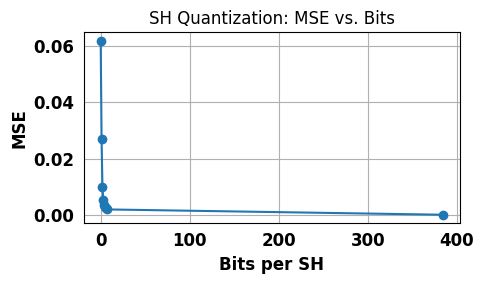

In [42]:
from sklearn.cluster import KMeans

sh_flat = sh.reshape(len(sh), -1)  # [N, 48]
k_list = [1, 2, 4, 8, 16, 32, 64, 128, 'scalar']
errors = []

for k in k_list:
    if isinstance(k, int):
        kmeans = KMeans(n_clusters=k, random_state=0).fit(sh_flat)
        labels = kmeans.labels_
        centroids = kmeans.cluster_centers_  # shape: [k, 48]
        recon_sh = centroids[labels]
        bits_per_sh = np.log2(k)
    else:
        # 标量量化，每通道做 8-bit 线性量化
        vmin, vmax = sh_flat.min(axis=0), sh_flat.max(axis=0)
        sh_normed = (sh_flat - vmin) / (vmax - vmin)
        q = np.round(sh_normed * 255)
        recon_sh = q / 255 * (vmax - vmin) + vmin
        bits_per_sh = 8 * sh_flat.shape[1]  # 48 dims * 8-bit

    mse = np.mean((sh_flat - recon_sh) ** 2)
    psnr_val = psnr(sh_flat, recon_sh)
    errors.append((bits_per_sh, mse))

    print(f"\n🎯 SH Quantization using k={k} {'(VQ)' if isinstance(k, int) else '(Scalar 8-bit per dim)'}")
    print(f"MSE: {mse:.4e} | PSNR: {psnr_val:.2f} dB | Bits per SH: {bits_per_sh:.2f}")

# 绘制 MSE vs Bits 曲线
plt.figure(figsize=(5,3))
bit_vals, mse_vals = zip(*errors)
plt.plot(bit_vals, mse_vals, marker='o')
plt.xlabel("Bits per SH")
plt.ylabel("MSE")
plt.title("SH Quantization: MSE vs. Bits")
plt.grid(True)
plt.tight_layout()
plt.show()

### 🤔 向量量化的简化理解

向量量化（Vector Quantization, VQ）并不是“对每个通道各选一个代表然后拼接”，  
而是将整个 SH 向量（如 48 维）作为一个整体看待。

#### ✅ 正确理解：
我们从所有 SH 向量中学习出 $k$ 个完整的代表性向量（centroids），每个也是 48 维。  
然后将每个原始向量替换为最接近的一个代表编号（如 0~k-1）。

这就意味着：

- 每个 SH 向量的所有通道是一起被压缩的；
- 不再关心每个维度的独立数值，而只关心“整体形状”是否相似；
- 存储成本只需 $\log_2(k)$ 个 bit，而不是 $48 \times N$ bits。

这种方式牺牲了部分通道级细节，但大幅节省存储，是一种**结构感知的压缩方法**。

但我们也可以看到，如果用一个小的MLP代替球谐函数的系数计算，而把每个高斯的位置参数作为输入，也许可以得到一个总参数量更小的颜色参数，这就是**参数感知的压缩方法**。


### 📤 小结与后续工作：剪枝分析需迁移至渲染流程

本章集中于静态属性分布与量化压缩实验。然而，“剪枝”分析需依赖动态渲染流程中的可见性、alpha 贡献度等信息。

因此，下一步应构建一个独立的渲染推理模块，追踪每个高斯点在实际视角下的有效性，并基于其贡献进行稀疏性分析与剪枝策略评估。

